# Dog Breed Classification using InceptionV3 CNN Model on Stanford Dogs Dataset
<!-- ## Abstract -->
The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.

I have used the InceptionV3 CNN Model, which is pre-trained on the ImageNet dataset for classification. Data augementation has been used for making the model generalize better and also to avoid overfitting. The model achieved an accuracy of 80% on validation set, which is decent enough for this dataset.

# Installing and Importing Libraries

In [2]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

# Dataset

In [3]:
train_data_dir = "../input/stanford-dogs-dataset/images/Images/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [4]:
def get_images(image_dir):

    image_index = 0
    image_arr_size= img_width * img_height * channels
    images = np.ndarray(shape=(num_images, image_arr_size))
    labels = np.array([])                       

    for type in os.listdir(image_dir)[:50]:
        type_images = os.listdir(image_dir + type)
        labels= np.append(labels, type.split('-')[1])
        
        for image in type_images[:1]:
            image_file = os.path.join(image_dir, type + '/', image)
            image_data = mpimg.imread(image_file)
            image_resized = resize(image_data, (img_width, img_height), anti_aliasing=True)
            images[image_index, :] = image_resized.flatten()
            print (type, ':', image)
            image_index += 1

    return (images, labels)

def plot_images(instances, images_per_row=10, **options):
    size = img_width
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(img_width, img_height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((img_width, img_height * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(20,20))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.savefig('dogs_images.png', transparent= True, bbox_inches= 'tight', dpi= 900)
    plt.show()

n02085620-Chihuahua : n02085620_275.jpg
n02088238-basset : n02088238_9577.jpg
n02092339-Weimaraner : n02092339_1700.jpg
n02092002-Scottish_deerhound : n02092002_4230.jpg
n02110958-pug : n02110958_14984.jpg
n02108000-EntleBucher : n02108000_748.jpg
n02115913-dhole : n02115913_2542.jpg
n02116738-African_hunting_dog : n02116738_500.jpg
n02094114-Norfolk_terrier : n02094114_2625.jpg
n02113023-Pembroke : n02113023_2970.jpg
n02086646-Blenheim_spaniel : n02086646_1182.jpg
n02108915-French_bulldog : n02108915_1343.jpg
n02097130-giant_schnauzer : n02097130_1780.jpg
n02099712-Labrador_retriever : n02099712_9373.jpg
n02098105-soft-coated_wheaten_terrier : n02098105_1434.jpg
n02110806-basenji : n02110806_6380.jpg
n02085782-Japanese_spaniel : n02085782_3030.jpg
n02104365-schipperke : n02104365_4258.jpg
n02089973-English_foxhound : n02089973_4010.jpg
n02087046-toy_terrier : n02087046_6513.jpg
n02089867-Walker_hound : n02089867_1082.jpg
n02086079-Pekinese : n02086079_347.jpg
n02093428-American_Staffo

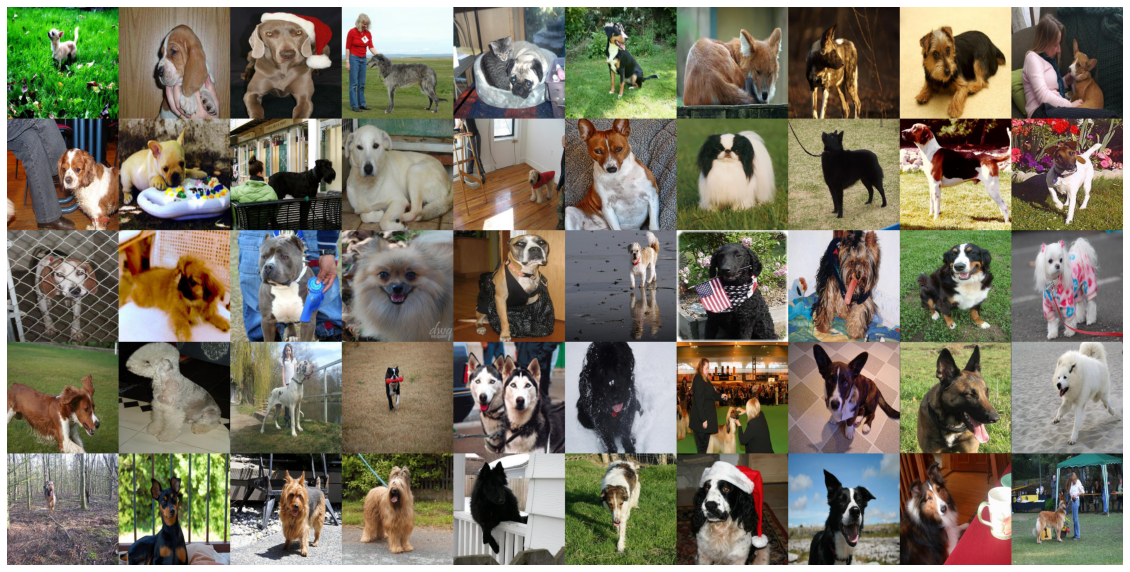

In [5]:
images, labels = get_images(train_data_dir)
plot_images(images)

# Preprocessing

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [8]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

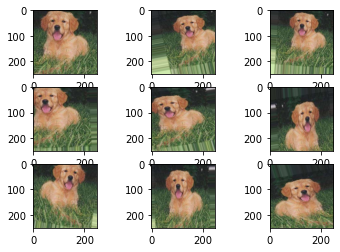

In [9]:
img = load_img('../input/stanford-dogs-dataset/images/Images/n02099601-golden_retriever/n02099601_5.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

# Model

In [10]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

In [11]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
#     print(layer,layer.trainable)
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


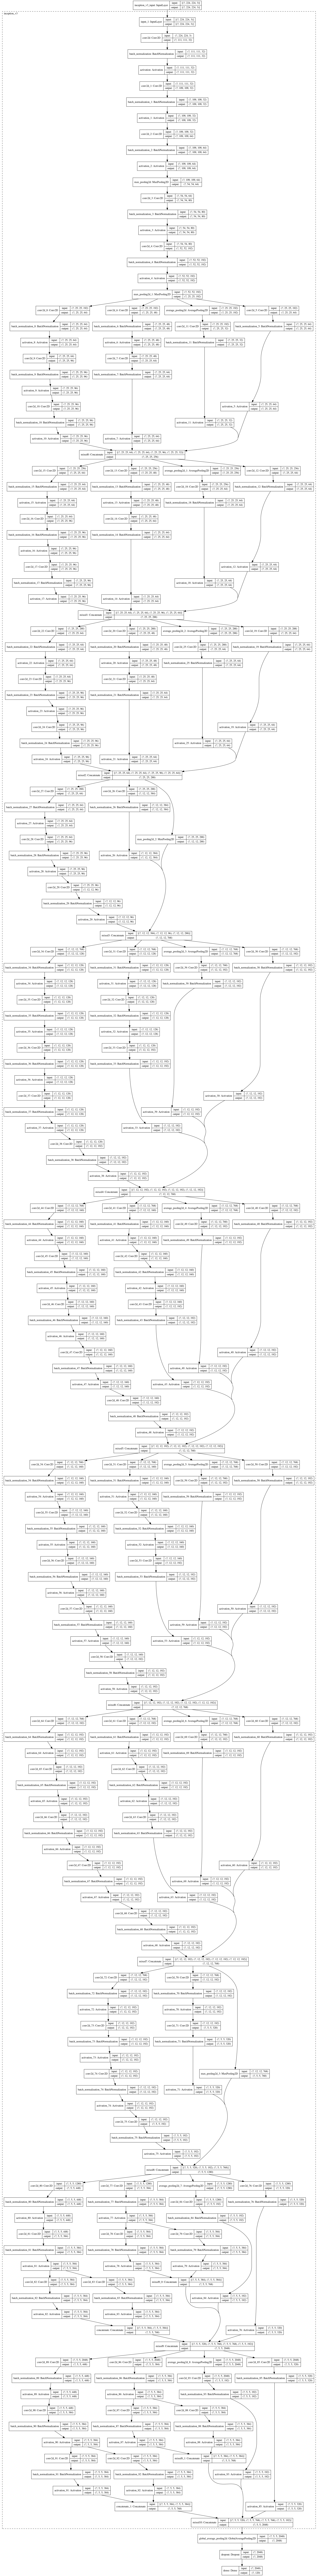

In [12]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

# Baseline Model Training

In [13]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [14]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [15]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.73642, saving model to baseline_model.h5
257/257 - 416s - loss: 3.4138 - accuracy: 0.2896 - val_loss: 1.7364 - val_accuracy: 0.6843
Epoch 2/30

Epoch 00002: val_loss improved from 1.73642 to 0.98991, saving model to baseline_model.h5
257/257 - 287s - loss: 1.6096 - accuracy: 0.6275 - val_loss: 0.9899 - val_accuracy: 0.7609
Epoch 3/30

Epoch 00003: val_loss improved from 0.98991 to 0.80997, saving model to baseline_model.h5
257/257 - 278s - loss: 1.1852 - accuracy: 0.6885 - val_loss: 0.8100 - val_accuracy: 0.7798
Epoch 4/30

Epoch 00004: val_loss improved from 0.80997 to 0.73872, saving model to baseline_model.h5
257/257 - 268s - loss: 1.0499 - accuracy: 0.7116 - val_loss: 0.7387 - val_accuracy: 0.7904
Epoch 5/30

Epoch 00005: val_loss improved from 0.73872 to 0.70333, saving model to baseline_model.h5
257/257 - 270s - loss: 0.9640 - accuracy: 0.7274 - val_loss: 0.7033 - val_accuracy: 0.7937
Epoch 6/30

Epoch 00006: val_loss impro

In [16]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

64/64 [==============================] - 23s 352ms/step - loss: 0.6417 - accuracy: 0.8084
Validation Loss:  0.6416965126991272
Validation Accuracy:  0.8084479570388794


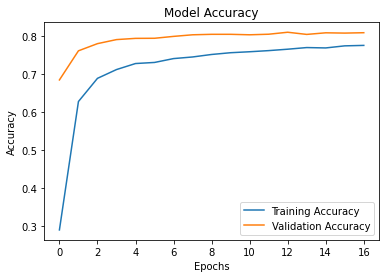

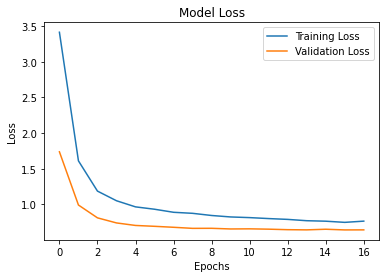

In [17]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()